# Лабораторная работа №6: генерация текстов
Подготовили :

* Залесская Галя;
* Максимов Артем;
* Соколова Света;
* Шилов Слава.

In [ ]:
import sys
import os
import os.path
import random
import shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!cp drive/'My Drive'/Lab6/arxiv.csv .

Эта лаба оказалась очень жесткой с точки зрения вычислительных затрат. Запускали параллеьно в разных ноутбуках и все равно у некоторых из нас отнимали акселераторы(видимо из-за того, что слишком долго использовали бесплатные GPU/TPU), что 

а) крашило сессию, стирая все результаты;

б) приводило к тому, что особо тяжелые модельки обучались по часу на эпоху

Поэтому мы написали функции для сохранения/загрузки модели для дообучения. Результат в клетке ниже:

In [ ]:
#!ls drive/'My Drive'/Lab6_models #which models are saved
model_path = "/content/drive/My Drive/Lab6_models/"

# Часть 1. Английские тексты

## Датасет

In [ ]:
dataset = pd.read_csv('arxiv.csv')['summary']
dataset

0        In summary of the research findings presented ...
1        In this paper, structural controllability of a...
2        We present a Deep Cuboid Detector which takes ...
3        In this paper, we study the trade-off between ...
4        In this paper, we propose a characterization o...
                               ...                        
27183    Being motivated by the multilayer RECOS (REcti...
27184    Understanding tie strength in social networks,...
27185    We present pyroomacoustics, a software package...
27186    Joint image filters leverage the guidance imag...
27187    Sentiment analysis aims to uncover emotions co...
Name: summary, Length: 27188, dtype: object

Несмотря на то, что пунктуация в этой задаче лишняя, мы решили попробовать оставить запятые и точки, так как генерящийся голый текст без знаков препинания выглядел совсем грустно. Спойлер: с знаками иногда выглядит лучше

In [ ]:
import re
allText = ' '.join([data.lower().replace('\n', ' ').replace('\x7f', ' ') for data in dataset])
allText = re.findall(r'\w| |\.|\,', allText) #See how punctuation influences the accuracy
len(allText)

28650965

Всего в датасете 28,6М символов. 

Построим словарики для маппинга 'символ словаря' -> 'номер' и наоборот для кодирования и декодирования слов 

In [ ]:
vocabulary = list(set(allText))
vocabulary.sort()

voc_indices = dict((c, i) for i, c in enumerate(vocabulary))
indices_voc = dict((i, c) for i, c in enumerate(vocabulary))

In [ ]:
voc_indices

{' ': 0,
 ',': 1,
 '.': 2,
 '0': 3,
 '1': 4,
 '2': 5,
 '3': 6,
 '4': 7,
 '5': 8,
 '6': 9,
 '7': 10,
 '8': 11,
 '9': 12,
 '_': 13,
 'a': 14,
 'b': 15,
 'c': 16,
 'd': 17,
 'e': 18,
 'f': 19,
 'g': 20,
 'h': 21,
 'i': 22,
 'j': 23,
 'k': 24,
 'l': 25,
 'm': 26,
 'n': 27,
 'o': 28,
 'p': 29,
 'q': 30,
 'r': 31,
 's': 32,
 't': 33,
 'u': 34,
 'v': 35,
 'w': 36,
 'x': 37,
 'y': 38,
 'z': 39}

In [ ]:
size_of_voc = len(voc_indices)
print(size_of_voc)

40


Размер словаря с учетом разрешенных знаков препинания - 40.

## Предобработка

# Из 4 участников команды только один работет с нейронками, но плоховат в PyTorch'е. Поэтому было решено вернуться к Keras'y, так как изучать новый фреймворк ради одной лабы это оверкил

Для работы character RNN мы решили предсказывать 20ю букву по предыдущим 19ти

Параметр step является гиперпараметром и влияет на размер обучающей выборки. 

При step == seqlen каждая последовательность будет просматриваться 1 раз. То есть мы будетм работать с 0-20м символами, потом 21-40, ...

В ходе работы мы пробовали изменить step до 10, чтобы было перекрытие: 0-20, 10-30 символы и т.д

В идеале step должен быть один, но тогда на каждой эпохе размер обучающей выборки будет около 20 миллионов и обучение на 1 эпоху будет оооочень долгим. Особенно когда акселераторы отбирают)


In [ ]:
seqlen = 20
step = 20
sentences = []
next_chars = []
for i in range(0, len(allText) - seqlen, step):
    sentences.append(allText[i: i + seqlen])
    next_chars.append(allText[i + seqlen])
print('nb sequences:', len(sentences))

nb sequences: 1432548


Превратим наши последовательности символов в вектора, чтбы можно было засунуть их в нейронку.

Каждый символ -> лист в котором size_of_voc элементов, 1 из которых True, а остальные - False

In [ ]:
print('Vectorization...')
x = np.zeros((len(sentences), seqlen, size_of_voc), dtype=np.bool)
y = np.zeros((len(sentences), size_of_voc), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, voc_indices[char]] = 1
    y[i, voc_indices[next_chars[i]]] = 1

Vectorization...


In [ ]:
x[0]

array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
         True, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [ True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [False, False, False, False, F

## Работа с моделями

Следующий код использовался при обучении. В финальной версии он не ранился, тк разные модели обучались в разное время и смысла от них особого нет(в финальном показе)

Просто чтобы показать как мы пришли к тому, что имеем

In [ ]:
logs_name = 'lstm_128'

In [ ]:
# import shutil
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = 0 
    shutil.copyfile(r'./' + logs_name + '.log', r'/content/drive/My Drive/Lab6_models/' + logs_name + '.log')
    for diversity in [0.2, 0.5, 1.0]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = ''.join(allText[start_index: start_index + seqlen])
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, seqlen, size_of_voc))
            for t, char in enumerate(sentence):
                x_pred[0, t, voc_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_voc[next_index]

            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

In [ ]:
#base model

from __future__ import print_function
from keras.callbacks import LambdaCallback, CSVLogger
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Dropout
from keras.optimizers import RMSprop

warnings.filterwarnings(action='always')

print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(seqlen, size_of_voc)))

model.add(Dropout(0.1))
model.add(Dense(size_of_voc, activation='softmax'))

optimizer = RMSprop(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = ['accuracy'])


Build model...


In [ ]:
warnings.filterwarnings(action='once')

from keras.callbacks import LambdaCallback, ModelCheckpoint
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
save_callback = ModelCheckpoint(model_path + logs_name + ".{epoch:02d}-{acc:.2f}.hdf5", monitor='acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max', period=1)
log_callback = CSVLogger(logs_name + '.log', append=True)

model.fit(x, y,
          batch_size=256,
          epochs=30,
          callbacks=[log_callback, print_callback, save_callback])

Epoch 1/30
1432548/1432548 [==============================] - 660s 461us/step - loss: 1.9861 - acc: 0.4209

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "in summary of the re"
in summary of the results the reconsing the reconsing the networks and the state in the proposed by a simple the reallonge a sumple to a sumparal and the really and and a sumple in the proposed and a simple introduce of the rearing the proposed and a proposed and in the results and the really and a structure of the computed the explicient in the reconsing the structure of the and the recurt consingrate the reconsing 
----- diversity: 0.5
----- Generating with seed: "in summary of the re"
in summary of the reconsing the the results the representation of how the somal state the reneation of the problem in orterm the ergimancal retection and of a veraare desers consint to a sengre the definent to a simples with the the station the inally that con the reloworated to replect of

In [ ]:
#to use loaded model
warnings.filterwarnings(action='once')

from keras.models import load_model
filename = model_path + 'model.05-0.66.hdf5'
model = load_model(filename, custom_objects=None, compile=True)

In [ ]:
warnings.filterwarnings(action='once')

from keras.callbacks import LambdaCallback, ModelCheckpoint
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
save_callback = ModelCheckpoint(model_path + logs_name + ".{epoch:02d}-{acc:.2f}.hdf5", monitor='acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max', period=1)
log_callback = CSVLogger(logs_name + '.log', append=True)

model.fit(x, y,
          batch_size=256,
          epochs=30,
          callbacks=[log_callback, print_callback, save_callback])

Epoch 1/30
1432548/1432548 [==============================] - 1583s 1ms/step - loss: 1.0909 - acc: 0.6651

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "in summary of the re"
in summary of the results of the state of the stateoftheart strategy in the second model and the stateoftheart system which are a convergence of the control of the spectral set of computation of the semantic and a simpler and the transfer to the control of the computational computation of the control of the control of the second computation of the stateoftheart system that are a simple and the proposed method is show
----- diversity: 0.5
----- Generating with seed: "in summary of the re"
in summary of the research to decoding the number of control and generate for the and limited state to the output deceition of the operational counterpart contributions in the electric process and the complexity of the spectral and software sensors to allow the computational concerts of the

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


 and synthetic transformation can be used to provide a set of regression problems in the simulation algorithms that are computationally localize a series of complex and more than the linear coding for interaction algorithm with the problem of an interference of here an algorithm to find the problem of meaning the settings of such a solution of a
----- diversity: 1.0
----- Generating with seed: "in summary of the re"
in summary of the recurrent network chieval language features and analyze this paper present as a scenes of adson training map along ys a. we present a lowcost emlets between cnd and benefit shortcallie to ours of into .e to which a 2dlm. we hava confided for singleinegrody and field and optimization problems. as analyze the reduction and realworld symbol is to show that in pthis to another grouphy outterfering zreso

Epoch 00003: acc improved from 0.66569 to 0.66690, saving model to /content/drive/My Drive/Lab6_models/base.03-0.67.hdf5
Epoch 4/30
1432548/1432548 [=========

## Модельки

In [ ]:
#for training visualization
import matplotlib.pyplot as plt
def check_training(filename):
  f = open(filename, 'r')
  ep = []
  acc = []
  loss = []
  header = f.readline()
  for line in f:
    epoh, accValue, lossValue = line.split(",")
    ep.append(float(epoh))
    acc.append(float(accValue))
    loss.append(float(lossValue))

  f.close()

  # Plot training & validation accuracy values
  plt.figure(figsize=(10, 5))
  plt.plot(ep[1:],acc[1:])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.show()

  # Plot training & validation loss values
  plt.figure(figsize=(10, 5))
  plt.plot(ep[1:],loss[1:])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.show()

  return ep, acc,loss

In [ ]:
#for generating chars based on trained models
def generate(model, start_sent='in this research it '):
    diversity = 0.5
    generated = '' + start_sent
    sentence = start_sent
    sys.stdout.write(sentence)
    for _ in range(2):
      for i in range(90):
          x_pred = np.zeros((1, seqlen, size_of_voc))
          for t, char in enumerate(sentence):
              x_pred[0, t, voc_indices[char]] = 1.

          preds = model.predict(x_pred, verbose=0)[0]
          next_index = sample(preds, diversity)
          next_char = indices_voc[next_index]
          sentence = sentence[1:] + next_char
          sys.stdout.write(next_char)
          sys.stdout.flush()
      print()

### Надо с чего то начинать

## 1 LSTM, step=20, optimizer=RmsProp(lr=0.001)

In [ ]:
from keras.models import load_model
filename = model_path + 'lstm_128.30-0.64.hdf5'
model = load_model(filename, custom_objects=None, compile=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [ ]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               86528     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 40)                5160      
Total params: 91,688
Trainable params: 91,688
Non-trainable params: 0
_________________________________________________________________
None


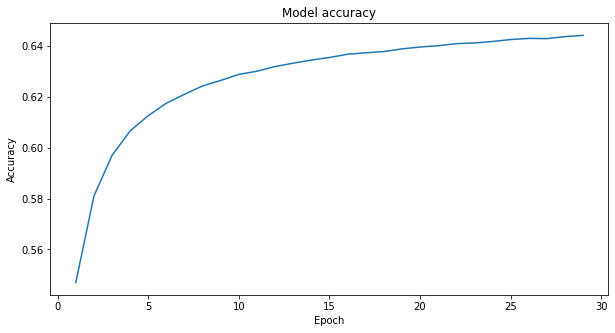

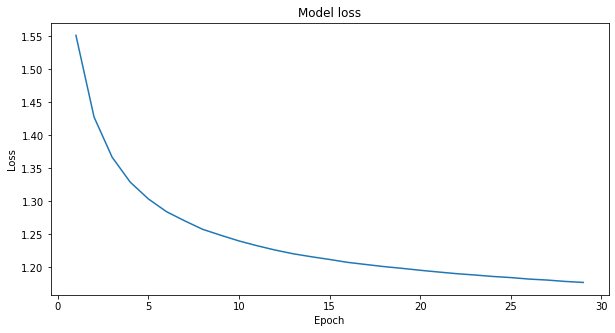

In [ ]:
architecture1 = 'lstm_128'
ep1, acc1, loss1 = check_training(model_path + 'lstm_128_final.log')

Как видим accuracy растет, loss падает. Все отлично и работает. Финальные результаты будут представлены в общей таблице ниже

In [ ]:
generate(model)

in this research it to use network architecture in the algorithm of inference and model with linear control st
ochastic and relative and recovering the performance of such model is investigated to expr


### 1 LSTM хорошо, а два - лучше

## 2 LSTM'a, step=20, optimizer=RmsProp(lr=0.001)

In [ ]:
filename = model_path + 'base.05-0.67.hdf5'
model = load_model(filename, custom_objects=None, compile=True)

In [ ]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 128)           86528     
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                5160      
Total params: 223,272
Trainable params: 223,272
Non-trainable params: 0
_________________________________________________________________
None


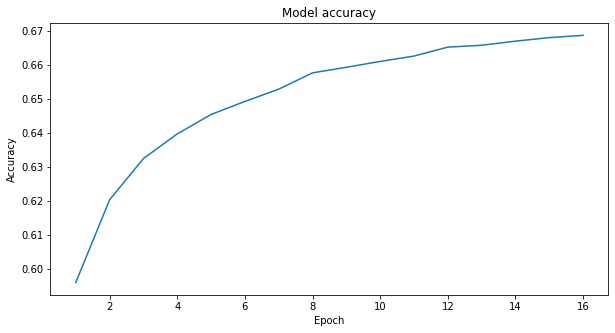

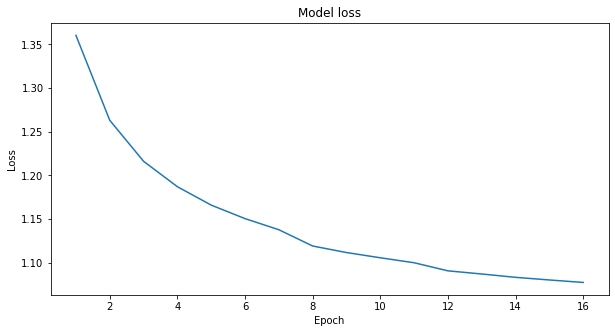

In [ ]:
architecture2 = 'base_rmsprop'
ep2, acc2, loss2 = check_training(model_path + 'base_final.log')

Результат похож на прошлую модель, но тут линия не такаягладкая как предыдущая. Accuracy иногда растет скачками(пусть и маленькими), Loss скачками падает. Вывод - эта модель получше предыдущей(неожиданно)

In [ ]:
generate(model)

in this research it on a neural network distinguishing users, and recovering context of the likelihood in orde
r to proper the proposed method to train comparison to a social networks is an experiments


### Во всем виноват RmsProp!

## 2 LSTM'a, step=20, optimizer=Adam

In [ ]:
filename = model_path + 'adam_0_001.28-0.68.hdf5'
model = load_model(filename, custom_objects=None, compile=True)

In [ ]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 128)           86528     
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                5160      
Total params: 223,272
Trainable params: 223,272
Non-trainable params: 0
_________________________________________________________________
None


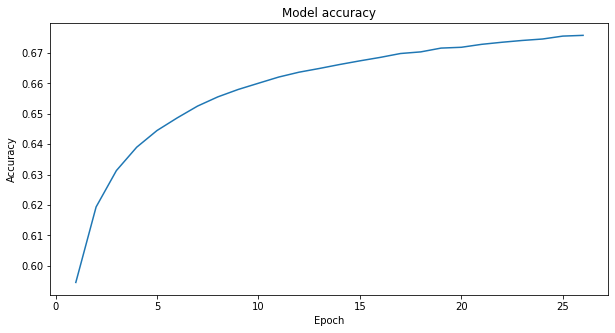

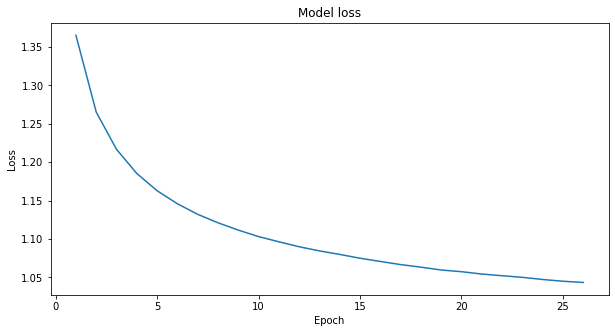

In [ ]:
architecture3 = 'adam'
ep3, acc3, loss3 = check_training(model_path + 'adam_final.log')

Чисто внешне изменения метрик такие же как и в предыдущих моделях. Похоже RmsProp не виноват

In [ ]:
generate(model)

in this research it is provided. the proposed model of the proposed method is not tested for all possible dist
ributions of the analysis of the visible transaction between the recurrent neural networks


### Размер имеет значение?!

## 2 LSTM'a, step=20, optimizer=RmsProp(lr=0.001), shape=256

In [ ]:
filename = model_path + 'rmsprop_256_256.09-0.68.hdf5'
model = load_model(filename, custom_objects=None, compile=True)

In [ ]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 256)           304128    
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                10280     
Total params: 839,720
Trainable params: 839,720
Non-trainable params: 0
_________________________________________________________________
None


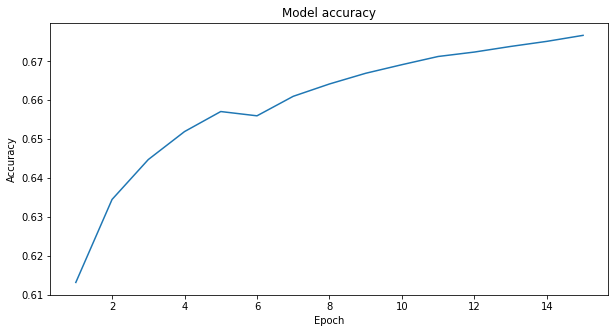

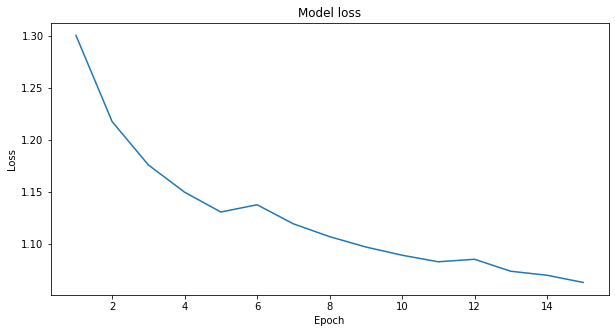

In [ ]:
architecture4 = 'rmsprop_256_256'
ep4, acc4, loss4 = check_training(model_path + 'rmsprop_256_256_final.log')

#### **Cпойлер**

Это будет лучшая модель, которую мы будем использовать дальше для русского текста. Забавно, что она обучалась не так хорошо как остальные и за 15 эпох дважды ухудшался loss и 1 раз accuracy

In [ ]:
generate(model)

in this research it is the optimal local metric method is considered to explain the communications for a distr
ibuted results in a composition of the network contains explicit and the resulting method 


Так, а эту нейронку я отправлю защищать свой Project Proposal

### Больше данных богу данных

## 2 LSTM'a, step=10, optimizer=RmsProp(lr=0.001)

In [ ]:
filename = model_path + 'step10.15-0.67.hdf5'
model = load_model(filename, custom_objects=None, compile=True)

In [ ]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 20, 128)           86528     
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 40)                5160      
Total params: 223,272
Trainable params: 223,272
Non-trainable params: 0
_________________________________________________________________
None


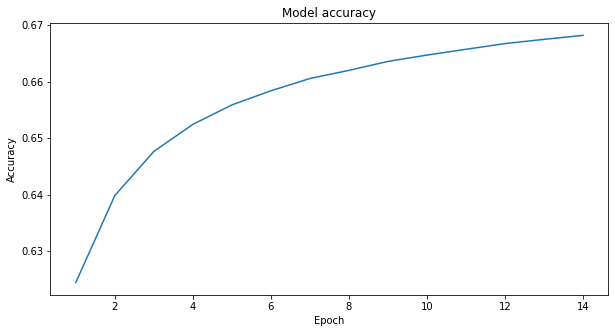

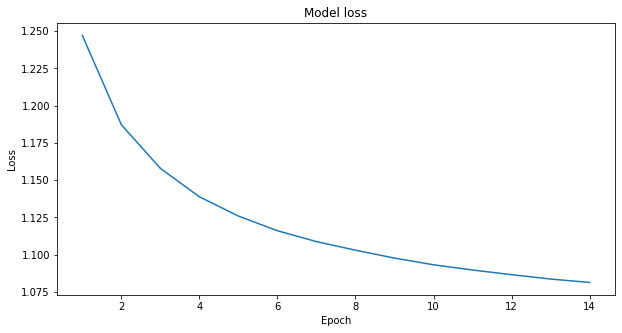

In [ ]:
architecture5 = 'step10'
ep5, acc5, loss5 = check_training(model_path + 'step10_final.log')

Уже привычный нам аутпут. Ничего нового

In [ ]:
generate(model)

in this research it is compared to the state of the analysis of the structure, we show that the proposed algor
ithm to a large code of the network transformations and comparison in the gap of the analy


### Говорят читать задание иногда полезно

##1 GRU, step=10, optimizer=RmsProp(lr=0.001)

In [ ]:
filename = model_path + 'gru_128.19-0.64.hdf5'
model = load_model(filename, custom_objects=None, compile=True)

In [ ]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 128)               64896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                5160      
Total params: 70,056
Trainable params: 70,056
Non-trainable params: 0
_________________________________________________________________
None


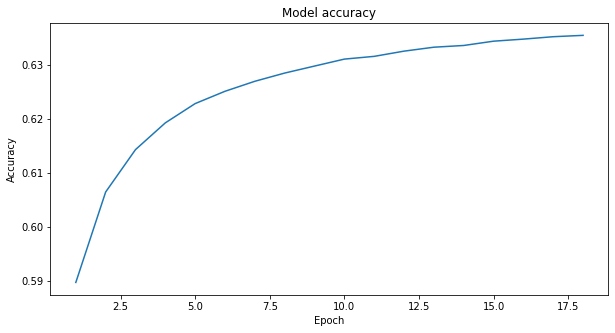

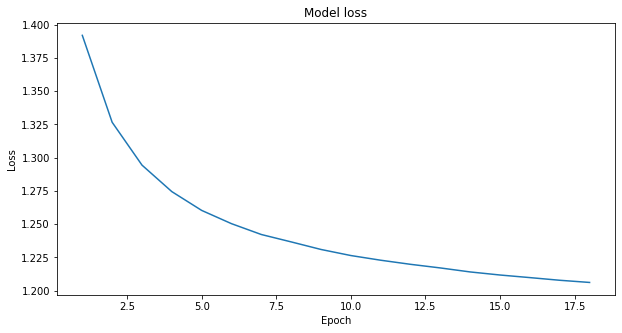

In [ ]:
architecture6 = 'gru_128'
ep6, acc6, loss6 = check_training(model_path + 'gru_128_final.log')

А данные точно разные?(Да) Картники одни и те же - обучение проходило верно

In [ ]:
generate(model)

in this research it condition of the proposed algorithm for the computing the state of the computational pertu
rbations of the latent of the conditional learning and conducted to explore the network an


### 2 все еще больше чем 1, но <3

## 2 GRU, step=10, optimizer=RmsProp(lr=0.001)

In [ ]:
filename = model_path + 'gru_128_128.17-0.66.hdf5'
model = load_model(filename, custom_objects=None, compile=True)

In [ ]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 20, 128)           64896     
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               98688     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                5160      
Total params: 168,744
Trainable params: 168,744
Non-trainable params: 0
_________________________________________________________________
None


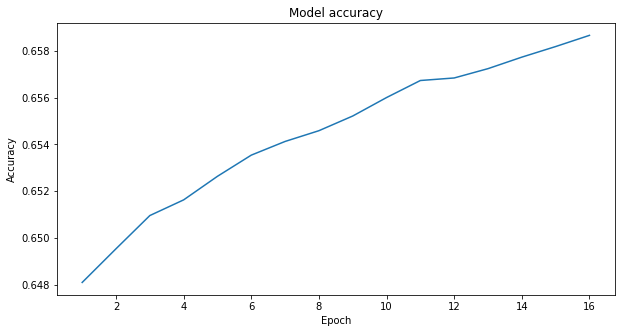

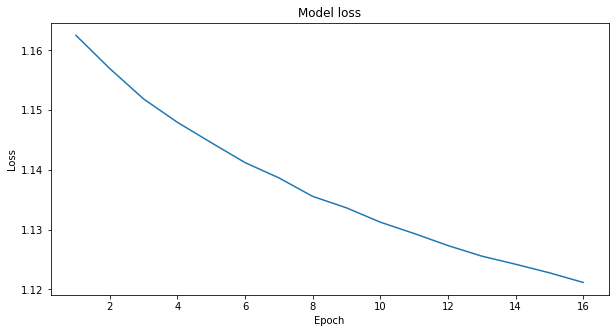

In [ ]:
architecture7 = 'gru_128_128'
ep7, acc7, loss7 = check_training(model_path + 'gru_128_128_final.log')

О, что-то новое! Результаты сразу лучше, но почти не изменяются(см. таблицу ниже). Поэтому графики не так выгнуты как на предыдущих

In [ ]:
generate(model)

in this research it is still given a set of set of convex algorithms for the proposed method for any problem i
s also achieved in the number of analyses in the scale tor that can be used to obtain the 


## Сравнение обученных моделей

In [ ]:
pd.DataFrame(data=[[max(acc1)]+acc1,[max(acc2)]+acc2,[max(acc3)]+acc3,[max(acc4)]+acc4,[max(acc5)]+acc5,
                   [max(acc6)]+acc6,[max(acc7)]+acc7], 
             index=[architecture1, architecture2, architecture3, architecture4, architecture5, 
                    architecture6, architecture7], columns=['best accuracy']+[str(i)+' epoch' for i in range(30)])

best accuracy   0 epoch  ...  28 epoch  29 epoch
lstm_128              0.644215  0.420879  ...  0.643715  0.644215
base_rmsprop          0.668600  0.469511  ...       NaN       NaN
adam                  0.675830  0.468884  ...       NaN       NaN
rmsprop_256_256       0.676700  0.498655  ...       NaN       NaN
step10                0.668212  0.531032  ...       NaN       NaN
gru_128               0.635521  0.502558  ...       NaN       NaN
gru_128_128           0.658664  0.646425  ...       NaN       NaN

[7 rows x 31 columns]

Cуществует очевидная проблема того, что модели обучались разное количество эпох - это связано с особенностями тренировок на колабе. Поэтому можно сравнивать модели по состоянию на 14 эпохе.

Модели с двойным LSTM с оптимизаторами RMSprop и Adam (вторая и третья строчка) идут одинаково, но RMSprop дает чуть больший результат (на 1%) за счет лишних 10 эпох обучения.

Самая лучшая модель - на четвертой сточке. Она состоит из 2 LSTM слоев размерности 256. Она довольно жирная, поэтому ее мы будем использовать для русского текста.

Модель, в которой мы уменьшили step с 20 до 10 (таким образом увеличив датасет в полтора раза - пятая строчка), дала примерно такой же результат, как и базовая модель (вторая строчка). Это значит, что увеличившееся в полтора раза время прохождения эпохи того не стоило.

Модель 2 двойным GRU (последняя строчка) достигает лучшей точности уже с первой эпохи, правда больше не растет :(



# Часть 2. Русские тексты

## Датасет

Нам нужен русский датасет, на котором будем обучаться. Как насчет Библии? Возможно, нам удастся создать новую религию)))(не сдавай нас полиции пожалуйста)))))

In [ ]:
bible_dataset = open(model_path+'bible_dataset.txt', 'r').read()
bible_dataset

'Ветхий Завет\nПервая книга Моисеева. БЫТИЕ\nГлава 1\nВ начале сотворил Бог небо и землю.\nЗемля же была безвидна и пуста, и тьма над бездною, и Дух Божий носился над водою.\nИ сказал Бог: да будет свет. И стал свет.\nИ увидел Бог свет, что он хорош, и отделил Бог свет от тьмы.\nИ назвал Бог свет днем, а тьму ночью. И был вечер, и было утро: день один.\nИ сказал Бог: да будет твердь посреди воды, и да отделяет она воду от воды. [И стало так.]\nИ создал Бог твердь, и отделил воду, которая под твердью, от воды, которая над твердью. И стало так.\nИ назвал Бог твердь небом. [И увидел Бог, что это хорошо.] И был вечер, и было утро: день второй.\nИ сказал Бог: да соберется вода, которая под небом, в одно место, и да явится суша. И стало так. [И собралась вода под небом в свои места, и явилась суша.]\nИ назвал Бог сушу землею, а собрание вод назвал морями. И увидел Бог, что это хорошо.\nИ сказал Бог: да произрастит земля зелень, траву, сеющую семя [по роду и по подобию ее, и] дерево плодовито

Нам очень понравились точки с запятыми, тч мы решили отсавить их и тут

In [ ]:
import re
allText = ''.join([data.lower().replace('\n', ' ').replace('\x7f', ' ') for data in bible_dataset])
allText = re.findall(r'\w| |\.|\,', allText) #See how punctuation influences the accuracy
allText = ''.join([data for data in allText if not data.isdigit()])
len(allText)

4012960

Наш датасет состоит из 4М символов, что в 7 раз меньше английского. Упс. Тогда стоит уменьшить step до 3, чтобы увеличить наш датасет до 1.3M примеров, как было и в тренировке с английским текстом.

Плохая новость в том, что в русском языке больше алфавит, что увеличит размер словаря. А хорошая в том, что для данного текста нам не нужны цифры. 

## Предобработка

In [ ]:
vocabulary = list(set(allText))
vocabulary.sort()
voc_indices = dict((c, i) for i, c in enumerate(vocabulary))
indices_voc = dict((i, c) for i, c in enumerate(vocabulary))
size_of_voc = len(voc_indices)
print(size_of_voc)

39


Таким образом, у нас есть словарь из 39 символов, то есть обучаемая модель не должна быть сложнее тех, что мы обучали на английском языке.

In [ ]:
seqlen = 20
step = 3
sentences = []
next_chars = []
for i in range(0, len(allText) - seqlen, step):
    sentences.append(allText[i: i + seqlen])
    next_chars.append(allText[i + seqlen])
print('nb sequences:', len(sentences))

print('Vectorization...')
x = np.zeros((len(sentences), seqlen, size_of_voc), dtype=np.bool)
y = np.zeros((len(sentences), size_of_voc), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, voc_indices[char]] = 1
    y[i, voc_indices[next_chars[i]]] = 1

nb sequences: 1337647
Vectorization...


In [ ]:
logs_name = 'russian_256_256'

In [ ]:
from keras.callbacks import LambdaCallback, CSVLogger, ModelCheckpoint
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
save_callback = ModelCheckpoint(model_path + logs_name + ".{epoch:02d}-{acc:.2f}.hdf5", monitor='acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max', period=1)
log_callback = CSVLogger(logs_name + '.log', append=True)

Using TensorFlow backend.


## Модель

Для русского языка возьмем самую жирную модель, которую мы обучали:

In [ ]:
#base russian model

from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Dropout
from keras.optimizers import RMSprop
warnings.filterwarnings(action='always')

print('Build model...')
model = Sequential()
model.add(LSTM(256, input_shape=(seqlen, size_of_voc), return_sequences=True))
model.add(LSTM(256, input_shape=(seqlen, size_of_voc)))

model.add(Dropout(0.4))
model.add(Dense(size_of_voc, activation='softmax'))

optimizer = RMSprop(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = ['accuracy'])

model.fit(x, y, batch_size=256,epochs=30, callbacks=[log_callback, print_callback, save_callback])

Build model...


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1453: ResourceWarning: unclosed file <_io.TextIOWrapper name='russian_256_256.log' mode='a' encoding='UTF-8'>
  **self._open_args)


Epoch 1/30
1337647/1337647 [==============================] - 3706s 3ms/step - loss: 1.9764 - acc: 0.4103

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "ветхий завет первая "
ветхий завет первая и возвратился на завести мои и на должно с ним и сказал господь бог сказал им в сем не собрал их и возвратился в серебро и сказал им на свое волоса и сказал им в семь и на своему и сказал ему и возвратился и все возвратить в него народа и возвратился и сказал им в сем народ и сказал господь бог ваш и народ и сказал ему и принесет и все возвратились все возвратился в сердце колена и из сынов израил
----- diversity: 0.5
----- Generating with seed: "ветхий завет первая "
ветхий завет первая по всех и вот как бы не проносили от него в городо мое, как он было послед и положил и приносил в него, как и скотал он сказал ему и сказал господь, и сказал господь бог сказал господь моисей и он на месте, и все служал в посему в покоре и прикорал и отвечал им положили 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


рдце моем и пришел и все дела и все славы наши на нем от себя в приношение в стране своей, и все дела и послал и сказал им в семь дней и все славы их, и он сказал им пойдет в сердце моем и в серд
----- diversity: 0.5
----- Generating with seed: "ветхий завет первая "
ветхий завет первая в сердце своем и все переселения меравилона и принесет тельца свои пришел и сказал им так говорит господь бог твой из другого из земли египетской, и как много призвания всех не открыл тебя с ними господь в последние всем приношения, и вот, он на поразу с нею и от народа на над ними приступит на голову ваших и от какого народа воспресят на ней пред господом, и сказал всем устав и просить построит е
----- diversity: 1.0
----- Generating with seed: "ветхий завет первая "
ветхий завет первая жителя испорнил я но неведит его, пусть покаинать меня в вавилон и как и другой слова сынов извалева, все духовных. и сказал ла моисей моисей при двроцах азота. глава  гора старает наступении и налых несжастия. с летами

In [ ]:
#to use loaded model
warnings.filterwarnings(action='once')

from keras.models import load_model
filename = model_path + 'russian_256_256.30-0.63.hdf5'
model = load_model(filename, custom_objects=None, compile=True)

In [ ]:
warnings.filterwarnings(action='once')

from keras.callbacks import LambdaCallback, ModelCheckpoint
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
save_callback = ModelCheckpoint(model_path + logs_name + ".{epoch:02d}-{acc:.2f}.hdf5", monitor='acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max', period=1)
log_callback = CSVLogger(logs_name + '.log', append=True)

model.fit(x, y,
          batch_size=256,
          epochs=30,
          callbacks=[log_callback, print_callback, save_callback])

Epoch 1/30
1337647/1337647 [==============================] - 497s 371us/step - loss: 1.2924 - acc: 0.5948

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "ветхий завет первая "
ветхий завет первая и поставлю вас, что вы не поступали пред ним в сердце своем и поставил в престоле дома и возвратился из сего дней и поставил его в пустыне и поставил вас и сказал ему сын человеческий поставил себе пред ним и сказал им в сем дне возлюбленный и принес на небеса и возвратились в сердце своем и не возвратились в земле египетской, и сказал ему посему ты поставил их на голове его, и пришли в сердце сво
----- diversity: 0.5
----- Generating with seed: "ветхий завет первая "
ветхий завет первая так благословение в поле своей и престол в городе иудейской, на народ служение и пришел и сказал народу давида саула, и сказали ему тот будет в тот день себе пред господом и поступили мы на голове наших на все дни из сосуды в пристаннике и приготовляет себе стражу, кото

Вообще мы обучали 40 эпох: 10 в 1й раз и потом 30 дообучили, когда вернули акселераторы, но логи по первым 10 потерлись. Поэтому график будет по 10-40 эпохам:

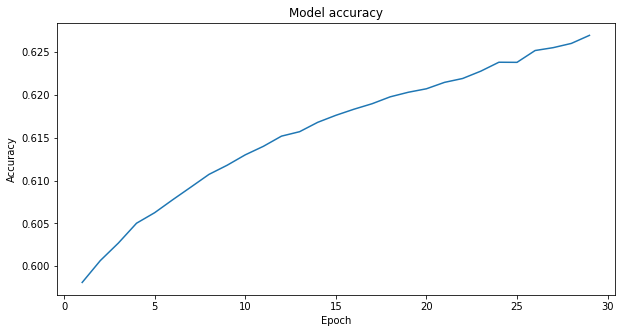

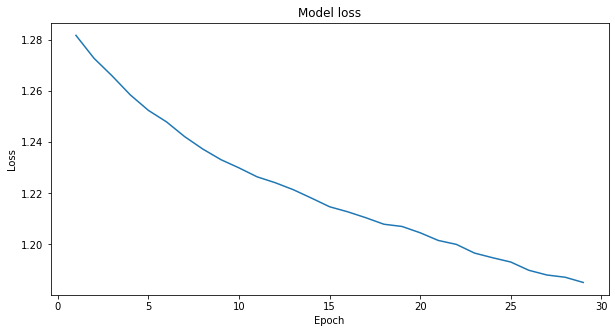

In [ ]:
_,accR,lossR = check_training(model_path + 'russian_256_256.log')

Уже знакомая картинка! Все обучалось нормально

In [ ]:
print("Final accuracy: {}".format(max(accR)))
print("Final loss: {}".format(max(lossR)))

Final accuracy: 0.626977072425764
Final loss: 1.2924171423456956


##Генерация

Попробуем погенерировать текст с помощью нашей модели.

Начнем с работы по теологии:

In [ ]:
generate(model, start_sent = "в этом исследовании ")

в этом исследовании и положи на все поколение, по силе им обольстить и поставил их священником, которые по сто
 стольму и возвратился и вот возложил на него все дела его не сделают им, и все дела его п


Забавно(или нет), что если прищуриться и очень сильно захотеть, то можно найти какой-то смысл в современных реалиях. Действительно пророческая книга!

Посмотрим как оно работает на котиках. Возьмем вот такого рыжего помогающего делать лабы по NLP котика:

![](https://media.giphy.com/media/MFstRkcJhudjn6gjWL/giphy.gif)

In [ ]:
generate(model, start_sent = "рыжий мякс вышел пог")

рыжий мякс вышел погибель, и вы все израильтяне и послал к нему они в воскресении составлявших и тотчас будет 
творить идите, и простерли сердце мое, и разодрал их в полны, и законом израилевым и посла


Благо Мякс домашний котик и гулять не выходит. Иначе принес бы всем погибель D:

Вот такое вот предсказание

![](https://media.giphy.com/media/hU4Yy9ikfRlcVI1a46/giphy.gif)

In [ ]:
generate(model, start_sent = "майнкрафт это моя жи")

майнкрафт это моя жить предо мною и сказал всякий день скорби твоей ты поступил на небесах и на всех страха их
, не обратившись, возлюбил его пред господа на вершине солнца со всех сторон сражался из д
